# Natural Language Processing

Here is the process for this Notebook:
- Why Data Mining?
- Text Preprocessing
- Vectorizing Text Data
    - Bag-of-Words using `CountVectorizer()`
    - Feature Extraction using `TfidfVectorizer()`
- Exploratory Data Analysis on Processed Data


## Import Libraries and Read in Data
___

In [1]:
# !pip install cleantext

In [2]:
# !python -m spacy download en_core_web_sm

In [2]:
# Import Libraries
import numpy as np
import pandas as pd
import pickle

# Preprocessing
import cleantext
import nltk
import re
import spacy
nlp = spacy.load("en_core_web_sm")

# Pipelines
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Visualizations
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "plotly_mimetype"

In [4]:
# Read in Data
postings = pd.read_csv('../data/postings/postings.csv', index_col='id')
# postings.drop(columns=['Unnamed: 0'], inplace=True)
postings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47915 entries, I0000 to M9066
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   job_title     47915 non-null  object
 1   job_docs      47915 non-null  object
 2   job_type      10000 non-null  object
 3   category      9118 non-null   object
 4   job_board     9310 non-null   object
 5   company_name  38845 non-null  object
 6   city          38599 non-null  object
 7   state         38432 non-null  object
 8   url           19067 non-null  object
 9   full_desc     47915 non-null  object
 10  pos_docs      47915 non-null  object
dtypes: object(11)
memory usage: 4.4+ MB


## Text Preprocessing
___
My goal is to prepare input text data into the word embedding models in a way that preserves syntactic meaning and lends itself to interpretation after processing. Therefore, I focused on normalizing the text by converting all the text to lowercase and removing punctuation and numbers. Since these documents are from job postings, I chose to remove emails, links, and numbers. I used the pandas `apply()` method with lambda functions to effectively make these modifications. I found regular expressions, encoding, and an open-source Python library called [cleantext](https://github.com/prasanthg3/cleantext) to be helpful.

In [5]:
# Remove non-ASCII characters
def remove_non_ascii(x):
    new_x = x.encode('ascii', errors='replace').decode() # replace non-ascii with '?'
    return new_x.replace('?', ' ')

postings['full_desc'] = postings['full_desc'].apply(lambda x: remove_non_ascii(x))

In [6]:
# Remove emails and links
def remove_links(x):
    return re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", x)
    
    
postings['full_desc'] = postings['full_desc'].apply(lambda x: remove_links(x))

In [7]:
# Normalize Text
def apply_cleantext(x):
    return cleantext.clean(x,
                           clean_all=False, # Execute all cleaning operations
                           extra_spaces=True,  # Remove extra white spaces 
                           stemming=False,  # Stem the words
                           stopwords=True,  # Remove stop words
                           lowercase=True,  # Convert to lowercase
                           numbers=True,  # Remove all digits 
                           punct=True,  # Remove all punctuations
                           stp_lang='english'  # Language for stop words
                          )

postings['full_desc'] = postings['full_desc'].apply(lambda x: apply_cleantext(x))

In [8]:
# Minimize posting length by removing parts of speech
pos_tags = ['PROPN', 'VERB', 'NOUN', 'ADJ']

# Function to Extract POS Tags and lemmatize tokens
def minimize_pos(x, pos_tags):
    '''
    Given a string of text, tokenize the text 
    and pull out only the nouns and verbs.
    '''
    doc = nlp(x)
    return ' '.join([str(token.lemma_) for token in doc if token.pos_ in pos_tags])

# Apply function to job posting data
postings['pos_docs'] = postings['full_desc'].apply(lambda x: minimize_pos(x, pos_tags))

In [9]:
postings.head()

,job_title,job_docs,job_type,category,job_board,company_name,city,state,url,full_desc,pos_docs
id,,,,,,,,,,,
I0000,"manager, implementation",Ceridian . Makes Work Life Better ™ Th...,NaN,NaN,NaN,ceridian,Saint Petersburg,FL,NaN,manager implementation ceridian makes work lif...,manager implementation ceridian make work life...
I0001,account executive (digital sales),Salem Media Group in the Twin Cities ...,NaN,NaN,NaN,salem media group,Eagan,MN,NaN,account executive digital sales salem media gr...,account executive digital sale salem medium gr...
I0002,"manager, sales development",We are growing! Join us to make subscripti...,NaN,NaN,NaN,recurly,San Francisco,CA,NaN,manager sales development growing join us make...,manager sale development grow join make subscr...
I0003,human resources expert,Description :ALL ABOUT TARGET As part of our...,NaN,NaN,NaN,target,Glendale,CA,NaN,human resources expert description target part...,human resource expert description target part ...
I0004,cell phone technician,**LOOOKING TO HIRE WITHIN DAYS AND START ASAP*...,NaN,NaN,NaN,the fix cell phone/computer repair,Silver Spring,MD,NaN,cell phone technician loooking hire within day...,cell phone technician loooking hire day start ...


In [19]:
# Export dataframe with cleaned job postings
postings.to_csv('../data/postings/postings.csv')

## Word Embedding
___

### Set X as vectorized 

In [11]:
X = postings['pos_docs']
X.shape

(47915,)

### Bag of Words (BoW)
A simple method is to assign a identifier to each word and count how many times it appears in each document. This method is used in `CountVectorizer()` and provides information about term frequency.


In [12]:
# Search over the following values of hyperparameters:
# Check (individual tokens) and also check (individual tokens and 2-grams).
# Check the optimal number of clusters using euclidian distances
cvec = CountVectorizer(max_features=1000,
                       ngram_range=(1,1),
                       min_df=2, 
                       max_df=0.85)

In [13]:
# Fit Count Vectorizer to training data.
X_cvec = cvec.fit_transform(X);

In [14]:
# Export fitted count vectorizer
with open('../data/pickles/cvec.pkl', 'wb') as p_out:
    pickle.dump(cvec, p_out)
    
# Export vector space from Count Vectorizer
with open('../data/pickles/X_cvec.pkl', 'wb') as p_out:
    pickle.dump(X_cvec, p_out)

### TF-IDF

By calculating **term-frequency (TF)** times the **inverse document-frequency (IDF)**, we can produce a sparse matrix where each word is represented by its probability of being present in a given document from a set of documents. `TfidfVectorizer()` is useful for understanding the importance of a word in a set of documents. I chose to use this vectorizing method, instead of a BoW.

In [15]:
# Instantiate TF-IDF Vectorizer
tvec = TfidfVectorizer(max_features=None,
                       ngram_range=(1,2), 
                       min_df=5, 
                       max_df=0.85, 
                       stop_words='english')

In [16]:
# Fit GridSearch to training data.
X_tvec = tvec.fit_transform(X)

In [17]:
# Export fitted Count Vectorizer
with open('../data/pickles/tvec.pkl', 'wb') as p_out:
    pickle.dump(tvec, p_out)
    
# Export vector space from Count Vectorizer
with open('../data/pickles/X_tvec.pkl', 'wb') as p_out:
    pickle.dump(X_tvec, p_out)

In [18]:
X_tvec.shape

(47915, 432246)

## Exploratory Analysis On Processed Data
___

In [140]:
postings.columns

<class 'pandas.core.frame.DataFrame'>
Index: 47915 entries, I0000 to M9066
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  47915 non-null  object
 1   job_title   47915 non-null  object
 2   job_docs    47915 non-null  object
 3   city        38599 non-null  object
 4   state       38432 non-null  object
 5   full_desc   47915 non-null  object
 6   pos_docs    47915 non-null  object
 7   char_count  47915 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 4.3+ MB


In [10]:
# Class for plotting functions
class EDAPlots:
    def __init__(self):
        pass
    
    # Violin with boxplot
    def plot_violin(self, data, y_column, x=None):
        fig = px.violin(df, y=y_column, x=x, box=True, points='all')
        fig.show()
        
    def plot_hist(self, data, x_column):
        fig = px.histogram(data, x=x_column, template='plotly_white', title='Job Title Counts')
        fig.update_xaxes(categoryorder='total descending').update_yaxes(title='Number of Occurences')
        fig.show()
        
    def plot_bar(self, data, x, y, title, template='plotly_white', labels=None, orientation='v', **kwargs):
        fig = px.bar(data, 
                     x=x, 
                     y=y, 
                     title=title, 
                     template=template,
                     labels=labels, 
                     orientation=orientation)
        fig.show()
        
# Instantiate EDAPlots
plots = EDAPlots()

### `job_title`

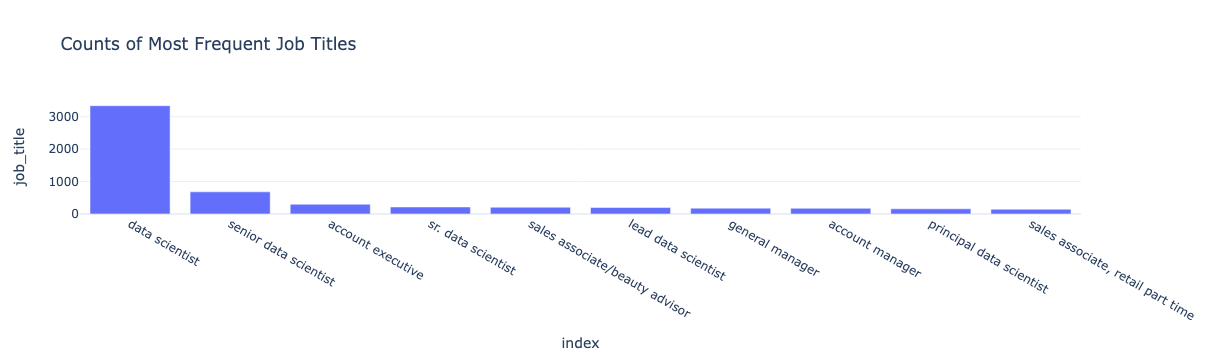

In [217]:
titles = pd.DataFrame(postings['job_title'].value_counts())[:10]
plots.plot_bar(data=titles, x=titles.index, y='job_title', title='Counts of Most Frequent Job Titles')


Many of the jobs are in data science field, but show that the job titles differ due to level and word order. This may suggest that other industries, like sales, also have high variance in job titles.

### `job_docs`

In [138]:
# Add column with character count
def get_char_count(df, columns, new_column='char_count'):
    df[new_column] = df[columns].apply(lambda x: sum([len(item) for item in x]))
    print("Describing Job Description Character Counts")  
    return plots.plot_violin(new_column)

Describing Job Description Character Counts


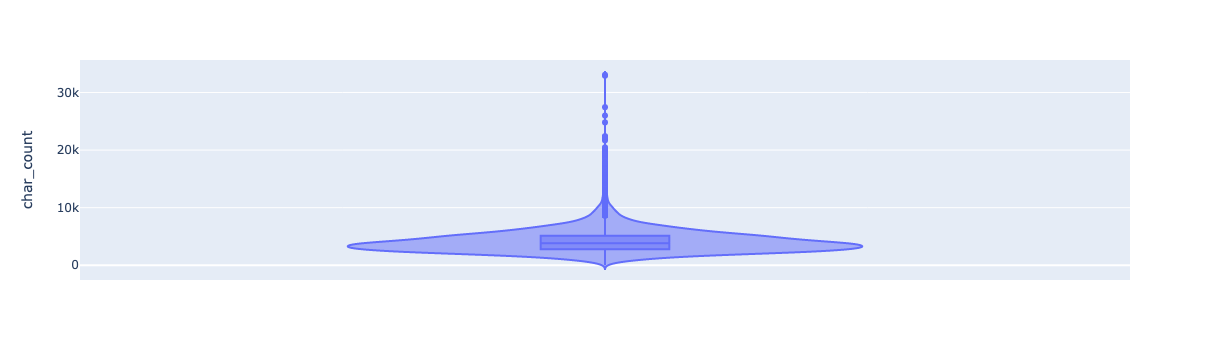

In [139]:
get_char_count(postings, 'job_docs')

Word count was not able to be used because of the number of combined terms. Character count is produced to get a sense of how long the descriptions are that are being put into the vector space for the recommender space. A majority of posts sit under 10,000, but what jobs are over 20k and 30k?

In [218]:
# Jobs with character counts below the 25th percentile
q1_char = postings.loc[postings['char_count'] <= 2791, 'job_title']

id
I0005                                    account executive
I0012                     lids assistant manager full-time
I0014                               office clerk assistant
I0023                              it sales representative
I0024                                     delivery manager
                               ...                        
M9062                     senior business services analyst
M9063        avp of corporate strategy & business strategy
M9064                  business analyst - registered nurse
M9065                                      systems analyst
M9066    sales & marketing team lead - competative spor...
Name: job_title, Length: 11995, dtype: object

In [142]:
# Jobs with character counts below the 75th percentile
postings.loc[postings['char_count'] >= 5140, 'job_title']

id
I0000                              Manager, Implementation
I0009                     Business Analyst/Project Manager
I0010                                        STORE MANAGER
I0013    Commercial Relationship Manager, VP or SVP - M...
I0015                            SVP, Cloud Transformation
                               ...                        
M8989                                Senior Java Developer
M8999                       Leader, New Business Solutions
M9003                        PMO Analyst/Knowledge Analsyt
M9019                                 Peoplesoft Developer
M9027                               API Platform Developer
Name: job_title, Length: 11986, dtype: object

There doesn't seem to be a clear difference between the longest and shortest job descriptions, after removing stop words and funcitonal parts of speech.

### POS documents

In [5]:
X = postings['pos_docs']

In [7]:
# Instantiate TF-IDF Vectorizer for bigrams
bigram_tvec = TfidfVectorizer(max_features=1000, ngram_range=(2, 2), min_df=5, max_df=0.85, stop_words='english')

# Fit TF-IDF Vectorizer on X data
bigram_vectors = bigram_tvec.fit_transform(X)

# Transform bigram vectors into a DataFrame.
bigram_df = pd.DataFrame(bigram_vectors.toarray(), columns=bigram_tvec.get_feature_names_out())

In [8]:
bigram_df

,ability ability,ability apply,ability build,ability communicate,ability develop,ability handle,ability identify,ability lead,ability learn,ability lift,...,year degree,year experience,year prefer,year preferred,year professional,year relate,year relevant,year require,year sale,year work
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.042099,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.297973,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.147689,0.000000
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.068531,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47910,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
47911,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
47912,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.081783,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.168231
47913,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


In [24]:
bigram_df.sum().sort_values(ascending=False)[]

data scientist           1880.396324
customer service         1601.332116
year experience          1520.429904
machine learning         1430.089486
communication skill      1214.031269
                            ...     
demand representative     112.769504
service use               110.549631
meet employee             110.097216
business include          107.670682
tax preparation            84.841977
Length: 1000, dtype: float64

Bigrams reveal more about the industries represented in the dataset. There are also specific verb and noun led combinations related to ability and qualificaitons.